This notebook presents a step-by-step tutorial on using the developed packages for price forecasting.

In [8]:
# Import the relevant libraries
import sys
sys.path.append('./')
import forecasting as fr
import importlib
import pandas as pd
importlib.reload(fr.get_data)
importlib.reload(fr.model)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
import optuna

## Data Acquisition

The helper function cleans up the data from API and returns the price and volume data as a pandas dataframe to play with.

In [9]:
query_start_date = '2024-06-10'
query_end_date = '2025-06-10'

dcl_data = fr.get_data.get_historical_fr_data_price_volume(query_start_date, query_end_date)

## Naive Forecast
Naive forecast is calculated as the rolling average of past 7 days.

In [10]:
price_naive_forecast = fr.model.rolling_average_multi_timeperiod(7, 6, dcl_data['clearingPrice'].iloc[:-6])
volume_naive_forecast = fr.model.rolling_average_multi_timeperiod(7, 6, dcl_data['clearedVolume'].iloc[:-6])

# Compare the naive forecast with the actual values for the last day
# Calculate the MAPE
mape_price_naive = mean_absolute_percentage_error(dcl_data['clearingPrice'].iloc[-6:], price_naive_forecast)
mape_volume_naive = mean_absolute_percentage_error(dcl_data['clearedVolume'].iloc[-6:], volume_naive_forecast)

print(f"Naive Forecast MAPE for Price: {mape_price_naive:.2%}")
print(f"Naive Forecast MAPE for Volume: {mape_volume_naive:.2%}")


Naive Forecast MAPE for Price: 51.29%
Naive Forecast MAPE for Volume: 6.19%


## LSTM Forecast

- Autocorrelation analysis (in a different notebook) suggests that the time-series data has a good correlation with lags of 6, 12, and 18 timesteps. So we use that to generate lagged features for our LSTM model.
- We also use an optimisation algorithm to get optimal values of the hyperparameters.
- Only focus on predicting prices since volume prediction is quite robust with naive forecast alone.

In [11]:
# Create lagged features for LSTM model

lag_times = [6, 12, 18]

# Create lagged features for the specified lag times
for lag in lag_times:
    dcl_data[f'Price_lag_{lag}'] = dcl_data['clearingPrice'].shift(lag)

# Just one lag for volume
dcl_data[f'Volume_lag_{6}'] = dcl_data['clearedVolume'].shift(6)

print("Lagged features created for both price and volume lags:", lag_times)

# Drop rows that don't have enough history for the lagged features
dcl_data = dcl_data.dropna()

Lagged features created for both price and volume lags: [6, 12, 18]


In [12]:
# Split the dataset into training and validation sets
# Removing the data for the last day since that will be used for prediction
tscv = TimeSeriesSplit(n_splits=2)
for train_index, test_index in tscv.split(dcl_data.iloc[0:-6, :]):
    X_train, X_valid = dcl_data.iloc[train_index], dcl_data.iloc[test_index]

print("Train shape:", X_train.shape, "Validation shape:", X_valid.shape)
print("Original data shape:", dcl_data.shape)

Train shape: (1444, 6) Validation shape: (722, 6)
Original data shape: (2172, 6)


In [13]:
# Generate the dataset windows that go into the LSTM model

series_train = X_train['clearingPrice'].values
X_lag_train = X_train.drop(columns=['clearingPrice', 'clearedVolume']).values
series_train = tf.convert_to_tensor(series_train, dtype=tf.float32)
X_lag_train = tf.convert_to_tensor(X_lag_train, dtype=tf.float32)

series_valid = X_valid['clearingPrice'].values
X_lag_valid = X_valid.drop(columns=['clearingPrice', 'clearedVolume']).values
series_valid = tf.convert_to_tensor(series_valid, dtype=tf.float32)
X_lag_valid = tf.convert_to_tensor(X_lag_valid, dtype=tf.float32)

# Create an optuna study and optimize the LSTM model hyperparameters
study = optuna.create_study(direction='minimize')
objective_func = fr.model.return_lstm_objective(
    series_train=series_train,
    X_lag_train=X_lag_train,
    series_valid=series_valid,
    X_lag_valid=X_lag_valid,
    num_lag_features= dcl_data.shape[1] - 2
)
study.optimize(objective_func, n_trials= 10)

[I 2025-07-25 13:02:53,251] A new study created in memory with name: no-name-b48092fa-1140-40c6-9f0d-939e13887111
/Users/prashant/Dropbox/Training/DS_SP/Core_DS_Projects/Energy_Price_Forecasting/Mine/Energy-Price-Forecasting/forecasting/model.py:200: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-8, 1e-3)
/Users/prashant/Dropbox/Training/DS_SP/Core_DS_Projects/.venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
[I 2025-07-25 13:03:00,536] Trial 0 finished with value: 2.624796628952026

In [14]:
best_params = study.best_params
print("Best hyperparameters found: \n", best_params)

Best hyperparameters found: 
 {'learning_rate': 1.414987342605203e-06, 'momentum': 0.8059429918104223, 'window_size': 64, 'batch_size': 64, 'shuffle_buffer_size': 800}


In [15]:
# Use the optimised parameters.
lr = 1.41* 10**-6
momentum = 0.8
WINDOW_SIZE = 64
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 800
FORECAST_HORIZON = 6

# Generate dataset windows.

train_set = fr.model.windowed_dataset_multi_input(
    series=series_train,
    X_lag_full=X_lag_train,
    window_size=WINDOW_SIZE,
    forecast_horizon=FORECAST_HORIZON,
    batch_size=BATCH_SIZE,
    shuffle_buffer=SHUFFLE_BUFFER_SIZE
)

valid_set = fr.model.windowed_dataset_multi_input(
    series=series_valid,
    X_lag_full=X_lag_valid,
    window_size=WINDOW_SIZE,
    forecast_horizon=FORECAST_HORIZON,
    batch_size=BATCH_SIZE,
    shuffle_buffer=SHUFFLE_BUFFER_SIZE
)

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Get the LSTM model
lstm_model = fr.model.get_LSTM_model(
    window_size= WINDOW_SIZE,  
    learning_rate= lr, 
    momentum = momentum, 
    num_lag_features= dcl_data.shape[1] - 2)


## Train the model

# Get initial weights
init_weights = lstm_model.get_weights()

# Reset the weights
lstm_model.set_weights(init_weights)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience= 10,
    restore_best_weights=True
)

# Fit the model
history = lstm_model.fit(
    train_set,
    epochs=100,
    validation_data=valid_set,
    callbacks=[early_stopping],
    verbose=1
)

# Check the forecast.
lstm_forecast = fr.model.lstm_forecast_multi_input(
    model=lstm_model,
    series=series_valid,
    X_lag_full=X_lag_valid,
    window_size=WINDOW_SIZE,
    forecast_horizon=FORECAST_HORIZON,
    batch_size=BATCH_SIZE
)

# Calculate the MAPE for the forecast for the last day (6 periods)
mape_forecast_model2 = mean_absolute_percentage_error(
    dcl_data['clearingPrice'].iloc[-6:],
    lstm_forecast[-1]
)  
print(f"MAPE for LSTM with optimised parameters: {mape_forecast_model2*100:.2f}%")
print(f"MAPE for naive forecast: {mape_price_naive*100:.2f}%")

Epoch 1/100
     22/Unknown 2s 38ms/step - loss: 94.2474 - mae: 94.7470

/Users/prashant/Dropbox/Training/DS_SP/Core_DS_Projects/.venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 93.7985 - mae: 94.2981 - val_loss: 62.0323 - val_mae: 62.5078
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 51.1446 - mae: 51.6339 - val_loss: 33.9693 - val_mae: 34.4543
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 25.9247 - mae: 26.3826 - val_loss: 19.3722 - val_mae: 19.8452
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 14.1726 - mae: 14.5832 - val_loss: 9.5469 - val_mae: 9.9987
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 6.1844 - mae: 6.5950 - val_loss: 1.6510 - val_mae: 2.0942
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.5591 - mae: 1.9733 - val_loss: 2.0580 - val_mae: 2.5125
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.1224 - mae: 1.5117 - val_loss: 1.8024 - val_mae: 2.2473
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.1027 - mae: 1.4962 - val_loss: 1.7742 - val_mae: 2.2181
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - 

Visualisation of the performance

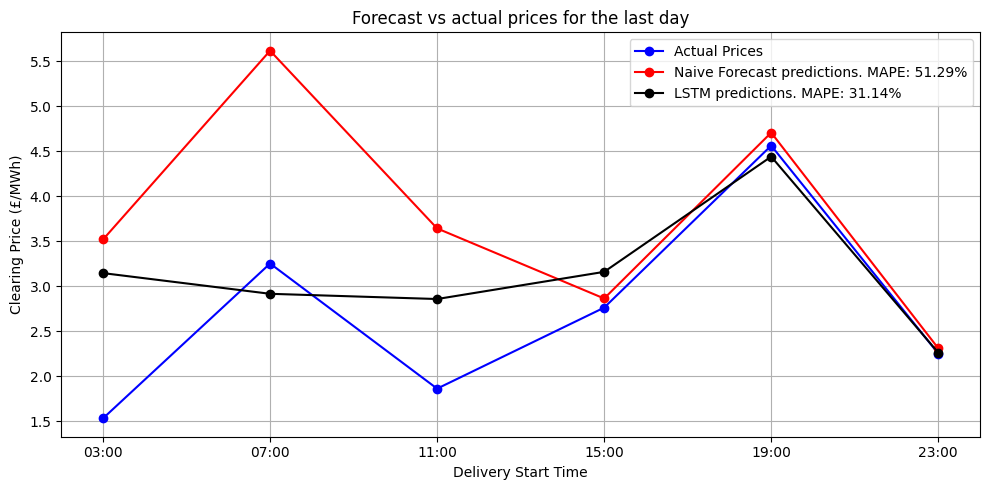

In [17]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

timestamp = dcl_data.index[-6:]

# First the price plot
ax1.plot(timestamp, dcl_data['clearingPrice'].iloc[-6:], marker='o', linestyle='-', color='blue', label='Actual Prices')
ax1.plot(timestamp, price_naive_forecast, marker='o', linestyle='-', color='red', label='Naive Forecast predictions. MAPE: {:.2f}%'.format(mape_price_naive * 100))
ax1.plot(timestamp, lstm_forecast[-1], marker='o', linestyle='-', color='black', label='LSTM predictions. MAPE: {:.2f}%'.format(mape_forecast_model2 * 100))

ax1.set_xlabel('Delivery Start Time')
ax1.set_ylabel('Clearing Price (£/MWh)')
ax1.set_title('Forecast vs actual prices for the last day')
ax1.legend()

ax1.set_xticks(timestamp) # Shows ticks only at actual data points
ax1.set_xticklabels(timestamp.strftime("%H:%M"), rotation=0) # Shows only the hour and minute
ax1.grid(True)

plt.tight_layout()
plt.show()